In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, auc,
                             classification_report, plot_confusion_matrix, roc_curve)

import imblearn
print(imblearn.__version__)

0.7.0


Since the pre-designated test dataset does not have include values for the target feature, the train dataset will be split further into a train/test set.

In [2]:
train = pd.read_csv('../data/Train.csv', index_col=0)
test = pd.read_csv('../data/Test.csv', index_col=0)

train.shape, test.shape

((13710, 41), (4570, 41))

In [3]:
train['target'] = train['target'].astype('int64')
test['target'] = test['target'].astype('int64')

In [4]:
# Split into test/train

X_train, y_train = train.drop(columns=['target', 'enrollee_id']), train.target
X_test, y_test = test.drop(columns=['target', 'enrollee_id']), test.target

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13710, 39), (13710,), (4570, 39), (4570,))

In [5]:
# Scale Data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# SMOTE

from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=0)
X_tr_bal, y_tr_bal = sm.fit_resample(X_train, y_train)

In [7]:
pd.DataFrame({
    'Counts':y_tr_bal.value_counts(),
    '%':y_tr_bal.value_counts()/len(y_tr_bal)*100
})

,Counts,%
1,10322,50.0
0,10322,50.0


# 0. Baseline Model

In [8]:
pd.DataFrame({
    'Counts':y_train.value_counts(),
    '%':y_train.value_counts()/len(y_train)*100
})

,Counts,%
0,10322,75.288111
1,3388,24.711889


As the majority response is 0 (most candidates are not looking for a job change), a baseline ZeroR classifier will be used as a basis of comparison for other models.

In [9]:
# Create a y_pred that is a series of 0s

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.75274   0.85893      4570
           1    0.00000   0.00000   0.00000         0

    accuracy                        0.75274      4570
   macro avg    0.50000   0.37637   0.42946      4570
weighted avg    1.00000   0.75274   0.85893      4570



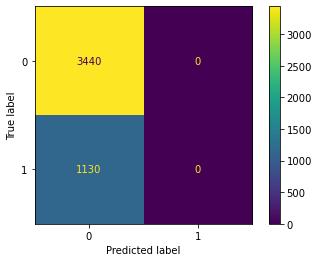

In [10]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.7527

# I. Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8144    0.9084    0.8589      3440
           1     0.5703    0.3699    0.4487      1130

    accuracy                         0.7753      4570
   macro avg     0.6923    0.6392    0.6538      4570
weighted avg     0.7541    0.7753    0.7575      4570



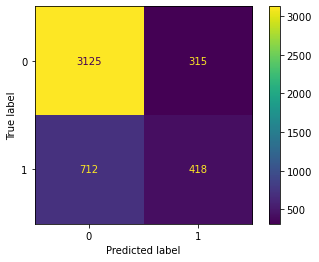

In [13]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

This model performs somewhat better than the baseline. Next, I'll try to optimize performance with Grid Search cross validation

{0: 0.1, 1: 0.9}    28.850923
{0: 0.2, 1: 0.8}    40.078393
{0: 0.3, 1: 0.7}    51.025237
{0: 0.4, 1: 0.6}    55.689278
{0: 0.5, 1: 0.5}    57.025921
dtype: float64


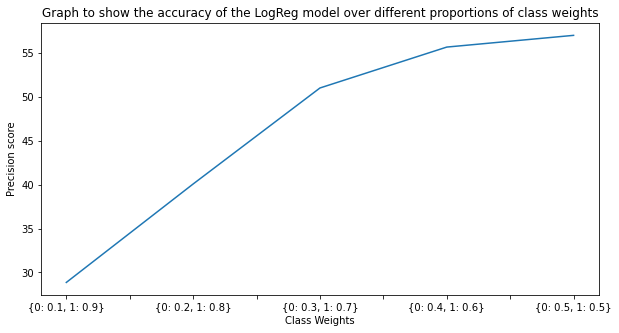

Wall time: 570 ms


In [14]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

pr = []

for i in class_weight:
    lm = LogisticRegression(class_weight=i, random_state=0)
    lm.fit(X_train_scaled, y_train)
    pr.append(precision_score(y_test, lm.predict(X_test_scaled)) * 100)
pr = pd.Series(pr, index=class_weight)

print(pr)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the LogReg model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Precision score')
pr.plot.line()
plt.show()

It seems that precision is higher when class weights are equal.

In [15]:
%%time

# Grid search of LR with different class weights

# Make pipeline
LR_pipeline = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

# Define parameters
params_LR = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    'LR__penalty': ['l2', 'l1',],
    'LR__solver': ['liblinear', 'saga'],
    'LR__class_weight': class_weight
}

# Fit model
gridcv_LR = GridSearchCV(LR_pipeline, param_grid=params_LR, cv=5, scoring='precision', verbose=0, n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

# Best model
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

Wall time: 26.1 s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=0.001, class_weight={0: 0.5, 1: 0.5},
                                     solver='saga'))]),
 {'LR__C': 0.001,
  'LR__class_weight': {0: 0.5, 1: 0.5},
  'LR__penalty': 'l2',
  'LR__solver': 'saga'},
 0.6159991621281943)

In [16]:
LR_best = gridcv_LR.best_estimator_

y_pred = LR_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7672    0.9791    0.8603      3440
           1     0.6000    0.0956    0.1649      1130

    accuracy                         0.7606      4570
   macro avg     0.6836    0.5373    0.5126      4570
weighted avg     0.7259    0.7606    0.6883      4570



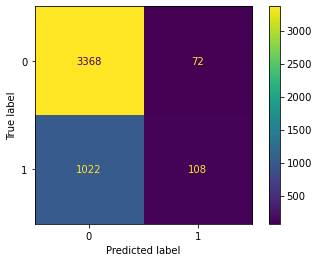

In [17]:
plot_confusion_matrix(LR_best, X_test, y_test);

The optimized logistic regression model performs about the same as the one with default settings.

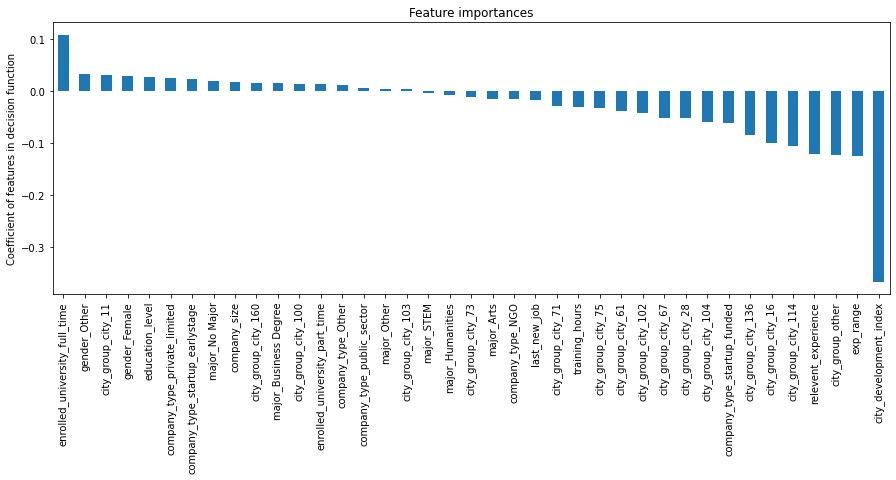

In [18]:
# Plot feature importance

importance = LR_best.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

It seems present enrollment and gender = female/other seem to be strong predictors of a positive case, with high CDI being the strongest predictor of a negative case

In [19]:
%%time

# Grid search for LR model with oversampling of minority class
from imblearn.pipeline import Pipeline as Pipe_Imb

# Make pipeline
LR_pipeline_bal = Pipe_Imb([('scaler', StandardScaler()), ('sm', SMOTE()), ('LR', LogisticRegression())])

# Define parameters
params_LR_bal = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    #'LR__penalty': ['l2', 'l1',],
    #'LR__solver': ['liblinear', 'saga'],
}

# Fit model
gridcv_LR_bal = GridSearchCV(LR_pipeline_bal, param_grid=params_LR_bal, cv=5, scoring='precision', n_jobs=-1)
gridcv_LR_bal.fit(X_train, y_train)

# Best model
gridcv_LR_bal.best_estimator_, gridcv_LR_bal.best_params_, gridcv_LR_bal.best_score_

Wall time: 3.04 s


(Pipeline(steps=[('scaler', StandardScaler()), ('sm', SMOTE()),
                 ('LR', LogisticRegression(C=10))]),
 {'LR__C': 10},
 0.4706641321633683)

In [20]:
LR_best_bal = gridcv_LR_bal.best_estimator_

y_pred = LR_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8618    0.7506    0.8024      3440
           1     0.4549    0.6336    0.5296      1130

    accuracy                         0.7217      4570
   macro avg     0.6584    0.6921    0.6660      4570
weighted avg     0.7612    0.7217    0.7349      4570



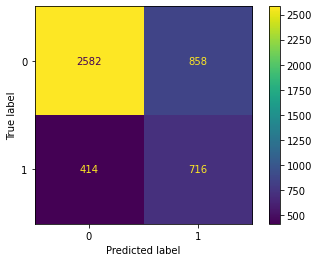

In [21]:
plot_confusion_matrix(LR_best_bal, X_test, y_test);

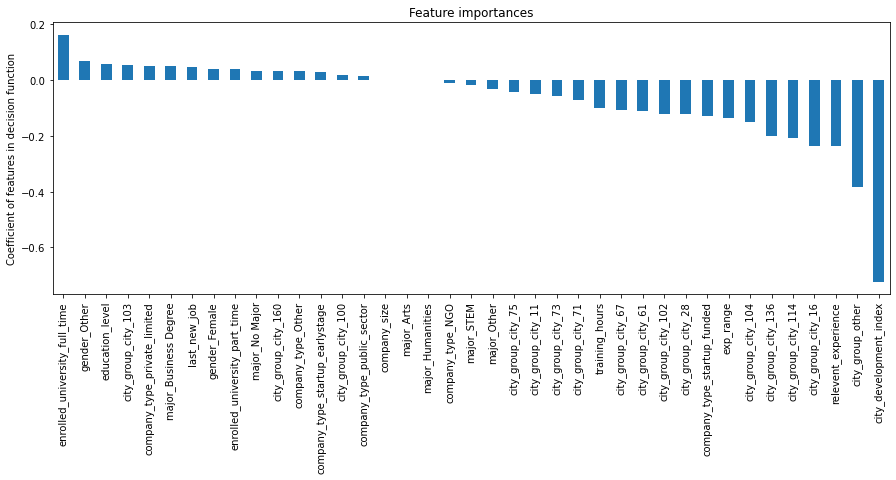

In [22]:
# Plot feature importance

importance = LR_best_bal.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_tr_bal.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

Feature importance is fairly similar to LogReg with class weights

--------------------------------------------------------------------

# II. Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8099    0.8767    0.8420      3440
           1     0.4988    0.3735    0.4271      1130

    accuracy                         0.7523      4570
   macro avg     0.6543    0.6251    0.6346      4570
weighted avg     0.7330    0.7523    0.7394      4570



The default RF model performs slightly worse than the LogReg models.

{0: 0.1, 1: 0.9}    50.313676
{0: 0.2, 1: 0.8}    50.000000
{0: 0.3, 1: 0.7}    49.817296
{0: 0.4, 1: 0.6}    50.839329
{0: 0.5, 1: 0.5}    49.881797
dtype: float64


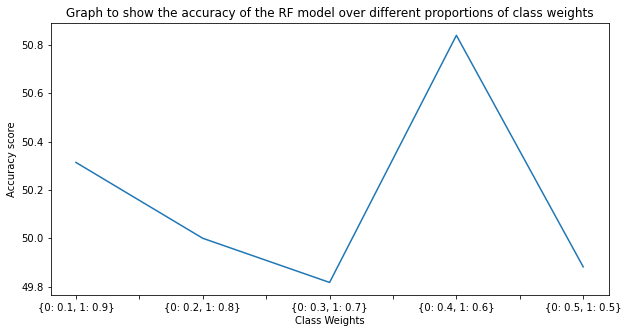

Wall time: 8.05 s


In [24]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

pr = []

for i in class_weight:
    clf = RandomForestClassifier(class_weight=i, random_state=0)
    clf.fit(X_train_scaled, y_train)
    pr.append(precision_score(y_test, clf.predict(X_test_scaled)) * 100)
pr = pd.Series(pr, index=class_weight)

print(pr)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the RF model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Accuracy score')
pr.plot.line()
plt.show()

It seems slightly under unbalanced (0.4 : 0.6) is optimal.

In [25]:
# Get a sense of the range of depths on default RF model

RF_depths = []

for i in range(len(RF.estimators_)):
    RF_depths.append(RF.estimators_[i].tree_.max_depth)
    
min(RF_depths), max(RF_depths)

(35, 50)

We can limit hyperparameter search to about this range of max depth.

In [26]:
%%time

# Make pipeline
RF_pipeline = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier())])

# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_RF = {
    'RF__n_estimators': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    'RF__max_depth': [10, 15, 20, 30, 50, 60], 
    #'RF__max_features': ['sqrt', 'log2', None], 
    #'RF__criterion': ['gini', 'entropy'],
    'RF__class_weight': class_weight
}

# Fit pipeline
RF_gridcv = GridSearchCV(RF_pipeline, params_RF, cv=5, scoring='precision', verbose=2, n_jobs=-1)
RF_gridcv.fit(X_train, y_train)

# Best model
RF_gridcv.best_estimator_, RF_gridcv.best_params_, RF_gridcv.best_score_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 8min 57s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('RF',
                  RandomForestClassifier(class_weight={0: 0.5, 1: 0.5},
                                         max_depth=10, n_estimators=300))]),
 {'RF__class_weight': {0: 0.5, 1: 0.5},
  'RF__max_depth': 10,
  'RF__n_estimators': 300},
 0.5941191638721234)

In [27]:
RF_best = RF_gridcv.best_estimator_

y_pred = RF_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8119    0.9134    0.8596      3440
           1     0.5743    0.3558    0.4393      1130

    accuracy                         0.7755      4570
   macro avg     0.6931    0.6346    0.6495      4570
weighted avg     0.7531    0.7755    0.7557      4570



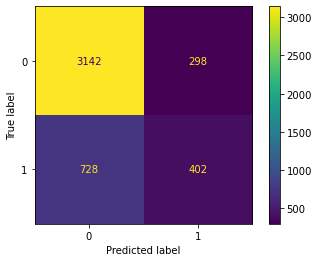

In [28]:
plot_confusion_matrix(RF_best, X_test, y_test);

The tuned model is definitely better than the default RF!

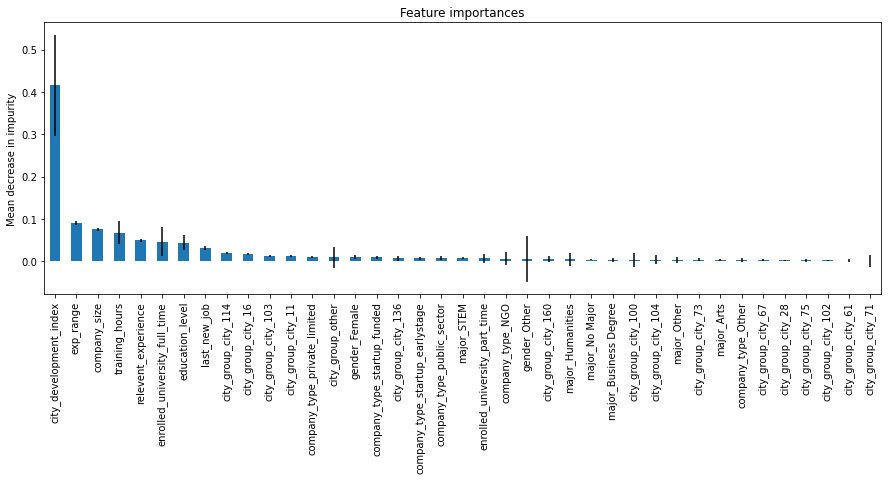

In [29]:
# Viewing feature importances

importance = RF_best.named_steps.RF.feature_importances_
forest_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in RF_best.named_steps.RF.estimators_], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(15,5))

forest_imp.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90);

In [30]:
%%time

# RF model with oversampling

# Make pipeline
RF_pipeline_bal = Pipe_Imb([('scaler', StandardScaler()), ('sm', SMOTE()), ('RF', RandomForestClassifier())])

# Define param grid
params_RF_bal = {
    'RF__n_estimators': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    'RF__max_depth': [10, 15, 20, 30, 50, 60], 
    #'RF__max_features': ['sqrt', 'log2', None], 
    #'RF__criterion': ['gini', 'entropy'],
}

# Fit model
RF_gridcv_bal = GridSearchCV(RF_pipeline_bal, params_RF_bal, cv=5, scoring='precision', verbose=2, n_jobs=-1)
RF_gridcv_bal.fit(X_train, y_train)

# Best model
RF_gridcv_bal.best_estimator_, RF_gridcv_bal.best_params_, RF_gridcv_bal.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 2min 53s


(Pipeline(steps=[('scaler', StandardScaler()), ('sm', SMOTE()),
                 ('RF', RandomForestClassifier(max_depth=10, n_estimators=300))]),
 {'RF__max_depth': 10, 'RF__n_estimators': 300},
 0.5546397653474707)

In [31]:
RF_best_bal = RF_gridcv_bal.best_estimator_

y_pred = RF_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8610    0.8250    0.8426      3440
           1     0.5275    0.5947    0.5591      1130

    accuracy                         0.7681      4570
   macro avg     0.6943    0.7098    0.7009      4570
weighted avg     0.7786    0.7681    0.7725      4570



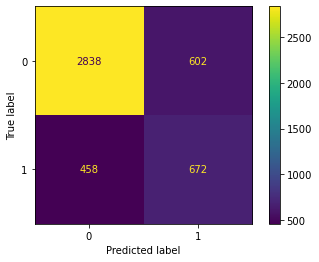

In [32]:
plot_confusion_matrix(RF_best_bal, X_test, y_test);

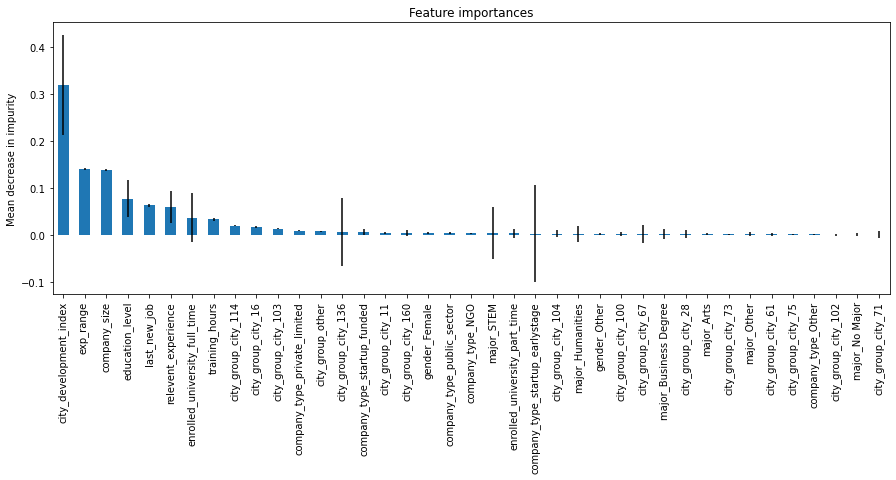

In [33]:
# Viewing feature importances

importance = RF_best_bal.named_steps.RF.feature_importances_
forest_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in RF_best_bal.named_steps.RF.estimators_], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(15,5))

forest_imp.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90);

--------------------------------------------------------------------------

# III. Support Vector Machine

### a) Linear SVC

In [34]:
from sklearn.svm import LinearSVC

In [35]:
# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_lin = {
    'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
    'SVC_Linear__class_weight': class_weight,
    'SVC_Linear__max_iter': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    #'SVC_Linear__dual': [False]
}

In [36]:
%%time

# Grid search for optimal hyperparameters

SVC_linear = Pipeline([('scaler', StandardScaler()), ('SVC_Linear', LinearSVC(dual=False, random_state=0))])

SVC_lin_gridcv = GridSearchCV(SVC_linear, params_SVC_lin, cv=5, scoring='precision', verbose=2, n_jobs=-1)
SVC_lin_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 21.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC_Linear',
                                        LinearSVC(dual=False,
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'SVC_Linear__class_weight': [{0: 0.1, 1: 0.9},
                                                      {0: 0.2, 1: 0.8},
                                                      {0: 0.3, 1: 0.7},
                                                      {0: 0.4, 1: 0.6},
                                                      {0: 0.5, 1: 0.5}],
                         'SVC_Linear__max_iter': [100, 200, 300, 400, 500]},
             scoring='precision', verbose=2)

In [37]:
SVC_lin_gridcv.best_estimator_, SVC_lin_gridcv.best_params_, SVC_lin_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC_Linear',
                  LinearSVC(C=0.01, class_weight={0: 0.5, 1: 0.5}, dual=False,
                            max_iter=100, random_state=0))]),
 {'SVC_Linear__C': 0.01,
  'SVC_Linear__class_weight': {0: 0.5, 1: 0.5},
  'SVC_Linear__max_iter': 100},
 0.6010833429208492)

In [38]:
SVC_linear_best = SVC_lin_gridcv.best_estimator_

y_pred = SVC_linear_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8172    0.9084    0.8604      3440
           1     0.5777    0.3814    0.4595      1130

    accuracy                         0.7781      4570
   macro avg     0.6975    0.6449    0.6599      4570
weighted avg     0.7580    0.7781    0.7613      4570



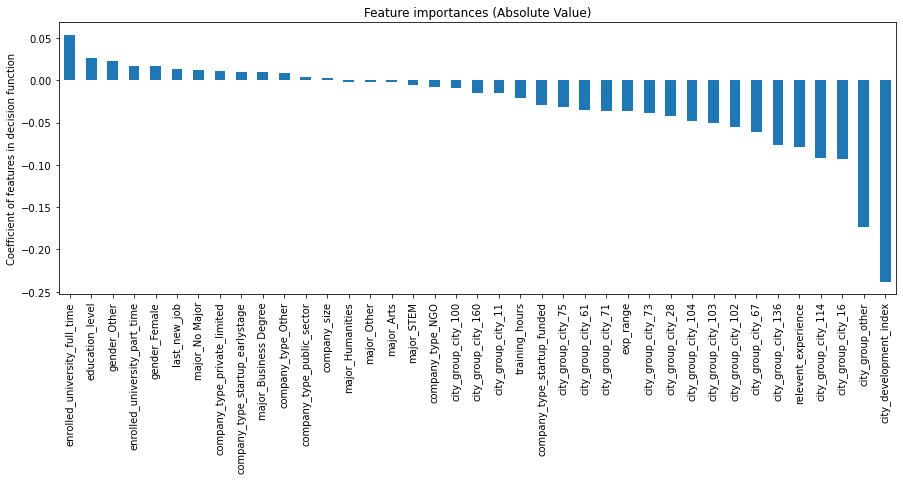

In [39]:
# Plot feature importance

importance = SVC_linear_best.named_steps.SVC_Linear.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances (Absolute Value)")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

Again, high predictors of a positive case are current university enrollment and non-male gender.

In [40]:
%%time

# SVC Linear with Oversampling of minority class

# Define param grid
params_SVC_lin_bal = {
    'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
    'SVC_Linear__max_iter': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    #'SVC_Linear__dual': [False]
}

# Grid search for optimal hyperparameters
SVC_linear_bal = Pipe_Imb([('scaler', StandardScaler()),
                       ('sm', SMOTE()),
                       ('SVC_Linear', LinearSVC(dual=False, random_state=0))])

# Fit model
SVC_lin_gridcv_bal = GridSearchCV(SVC_linear_bal, params_SVC_lin_bal, cv=5, scoring='precision', verbose=2, n_jobs=-1)
SVC_lin_gridcv_bal.fit(X_train, y_train)

# Best model
SVC_lin_gridcv_bal.best_estimator_, SVC_lin_gridcv_bal.best_params_, SVC_lin_gridcv_bal.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 15.7 s


(Pipeline(steps=[('scaler', StandardScaler()), ('sm', SMOTE()),
                 ('SVC_Linear',
                  LinearSVC(C=0.01, dual=False, max_iter=400, random_state=0))]),
 {'SVC_Linear__C': 0.01, 'SVC_Linear__max_iter': 400},
 0.47180354958593107)

In [41]:
SVC_linear_best_bal = SVC_lin_gridcv_bal.best_estimator_

y_pred = SVC_linear_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8624    0.7485    0.8014      3440
           1     0.4539    0.6363    0.5298      1130

    accuracy                         0.7208      4570
   macro avg     0.6581    0.6924    0.6656      4570
weighted avg     0.7614    0.7208    0.7343      4570



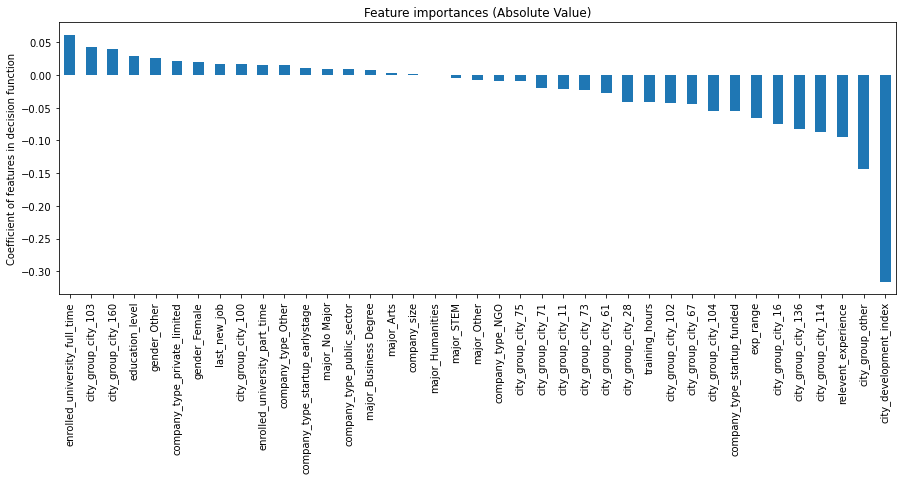

In [42]:
# Plot feature importance

importance = SVC_linear_best_bal.named_steps.SVC_Linear.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances (Absolute Value)")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

### b) SVC (nonlinear kernels)

In [43]:
from sklearn.svm import SVC

In [44]:
%%time

# Print accuracy along different values of c
c_range = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]
pr = []

for i in c_range:
    svc = SVC(C=i, random_state=0)
    svc.fit(X_train_scaled, y_train)
    pr.append(precision_score(y_test, svc.predict(X_test_scaled)) * 100)
pr = pd.Series(pr, index=c_range)

print(pr)

C:\Users\divzu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\divzu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.001      0.000000
0.010      0.000000
0.100     58.246657
0.500     58.390177
1.000     58.198925
2.000     57.887875
5.000     56.951220
10.000    56.380510
dtype: float64
Wall time: 1min 43s


#### RBF Kernel

In [45]:
%%time

# Make pipeline
SVC_nonlinear = Pipeline([('scaler', StandardScaler()), ('SVC', SVC(random_state=0))])

# Define param grid
class_weight = [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_rbf = {
    'SVC__kernel': ['rbf'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
    'SVC__class_weight': class_weight
}

# Grid search
SVC_rbf_gridcv = GridSearchCV(SVC_nonlinear, params_SVC_rbf, cv=5, scoring='precision', verbose=2, n_jobs=-1)
SVC_rbf_gridcv.fit(X_train, y_train)

# Best Model
SVC_rbf_gridcv.best_estimator_, SVC_rbf_gridcv.best_params_, SVC_rbf_gridcv.best_score_

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Wall time: 29min 14s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC',
                  SVC(C=0.1, class_weight={0: 0.4, 1: 0.6}, gamma=1,
                      random_state=0))]),
 {'SVC__C': 0.1,
  'SVC__class_weight': {0: 0.4, 1: 0.6},
  'SVC__gamma': 1,
  'SVC__kernel': 'rbf'},
 0.6466099660669581)

In [46]:
SVC_rbf_best = SVC_rbf_gridcv.best_estimator_

y_pred = SVC_rbf_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7639    0.9887    0.8619      3440
           1     0.6695    0.0699    0.1266      1130

    accuracy                         0.7615      4570
   macro avg     0.7167    0.5293    0.4942      4570
weighted avg     0.7406    0.7615    0.6801      4570



In [47]:
%%time

# RBF with oversampling of minority class

# Make pipeline
SVC_nonlinear_bal = Pipe_Imb([('scaler', StandardScaler()), ('sm', SMOTE()), ('SVC', SVC(random_state=0))])

# Define param grid
params_SVC_rbf_bal = {
    'SVC__kernel': ['rbf'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
}

# Grid search
SVC_rbf_gridcv_bal = GridSearchCV(SVC_nonlinear_bal, params_SVC_rbf_bal, cv=5, scoring='precision', n_jobs=-1)
SVC_rbf_gridcv_bal.fit(X_train, y_train)

# Best Model
SVC_rbf_gridcv_bal.best_estimator_, SVC_rbf_gridcv_bal.best_params_, SVC_rbf_gridcv_bal.best_score_

Wall time: 25min 27s


(Pipeline(steps=[('scaler', StandardScaler()), ('sm', SMOTE()),
                 ('SVC', SVC(C=0.1, gamma=1, random_state=0))]),
 {'SVC__C': 0.1, 'SVC__gamma': 1, 'SVC__kernel': 'rbf'},
 0.5420468693482632)

In [48]:
SVC_rbf_best_bal = SVC_rbf_gridcv_bal.best_estimator_

y_pred = SVC_rbf_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8083    0.8948    0.8493      3440
           1     0.5249    0.3540    0.4228      1130

    accuracy                         0.7611      4570
   macro avg     0.6666    0.6244    0.6361      4570
weighted avg     0.7382    0.7611    0.7439      4570



----------------------------------------------------------------------

# IV. XGBoost Model

In [49]:
%%time

import xgboost as xgb

XGB = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=0, eval_metric='error')

XGB.fit(X_train_scaled, y_train)
y_pred = XGB.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8204    0.8831    0.8506      3440
           1     0.5363    0.4115    0.4657      1130

    accuracy                         0.7665      4570
   macro avg     0.6784    0.6473    0.6582      4570
weighted avg     0.7502    0.7665    0.7554      4570

Wall time: 624 ms


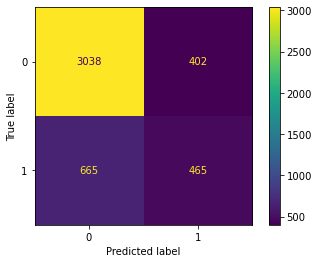

In [50]:
plot_confusion_matrix(XGB, X_test_scaled, y_test);

The default xgb model performs only slightly better than the baseline dummy model.

0.0001    57.010582
0.0010    57.180501
0.0100    57.407407
0.1000    57.964072
0.2000    56.719818
0.3000    57.013575
dtype: float64


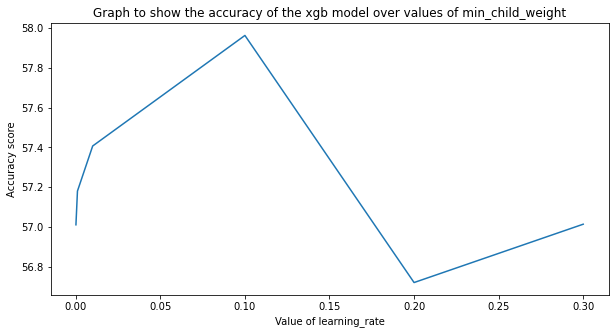

Wall time: 786 ms


In [51]:
%%time

# Print accuracy along different values of c
test = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
pr = []

for i in test:
    clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='error', 
                           learning_rate=i, n_estimators=10, random_state=0)
    clf.fit(X_train_scaled, y_train)
    pr.append(precision_score(y_test, clf.predict(X_test_scaled)) * 100)
pr = pd.Series(pr, index=test)

print(pr)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the xgb model over values of min_child_weight')
plt.xlabel('Value of learning_rate')
plt.ylabel('Accuracy score')
pr.plot.line()
plt.show()

In [52]:
%%time

# Make pipeline
xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('XGB', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                                               eval_metric='error', random_state=0))])

# Define param grid
class_weight = [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_xgb = {
    'XGB__n_estimators': [5, 10, 15, 20, 30, 40, 50], 
    'XGB__max_depth': [5, 10, 15], 
    'XGB__gamma': [2, 6, 10], 
    #'XGB__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
    #'XGB__min_child_weight': [0, 1, 2, 3, 4, 5, 6, 7, 8], 
}

# Grid search
xgb_gridcv = GridSearchCV(xgb_pipe, params_xgb, cv=5, scoring='precision', verbose=2, n_jobs=-1)
xgb_gridcv.fit(X_train, y_train)

# Best model
xgb_gridcv.best_estimator_, xgb_gridcv.best_params_, xgb_gridcv.best_score_

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Wall time: 1min 5s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('XGB',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, enable_categorical=False,
                                eval_metric='error', gamma=10, gpu_id=-1,
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=10, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=15,
                                n_jobs=6, num_parallel_tree=1, predictor='auto',
                                random_state=0, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, subsample=1,
                                tree_method='exact', use_label_encoder=False,
                        

In [53]:
XGB_best = xgb_gridcv.best_estimator_

y_pred = XGB_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8345    0.8808    0.8570      3440
           1     0.5634    0.4681    0.5114      1130

    accuracy                         0.7788      4570
   macro avg     0.6989    0.6745    0.6842      4570
weighted avg     0.7674    0.7788    0.7716      4570



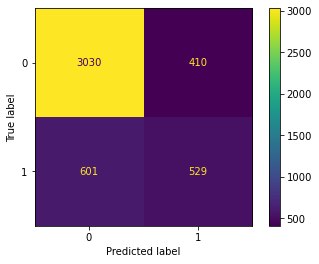

In [54]:
plot_confusion_matrix(XGB_best, X_test, y_test);

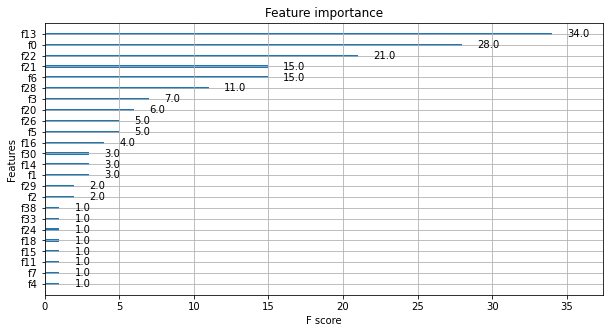

In [55]:
fig, ax = plt.subplots(figsize = (10, 5));
xgb.plot_importance(XGB_best.named_steps.XGB, ax=ax);

In [58]:
%%time

# XGB with oversampled minority class

# Make pipeline
xgb_pipe_bal = Pipe_Imb([('scaler', StandardScaler()),
                     ('sm', SMOTE()),
                     ('XGB', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                                               eval_metric='error', random_state=0))])

# Define param grid
params_xgb_bal = {
    'XGB__n_estimators': [5, 10, 15, 20, 30, 40, 50], 
    'XGB__max_depth': [5, 10, 15], 
    'XGB__gamma': [2, 6, 10], 
    #'XGB__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
    #'XGB__min_child_weight': [0, 1, 2, 3, 4, 5, 6, 7, 8], 
}

# Grid search
xgb_gridcv_bal = GridSearchCV(xgb_pipe_bal, params_xgb_bal, cv=5, scoring='precision', n_jobs=-1)
xgb_gridcv_bal.fit(X_train, y_train)

# Best model
xgb_gridcv_bal.best_estimator_, xgb_gridcv_bal.best_params_, xgb_gridcv_bal.best_score_

Wall time: 2min 1s


(Pipeline(steps=[('scaler', StandardScaler()), ('sm', SMOTE()),
                 ('XGB',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, enable_categorical=False,
                                eval_metric='error', gamma=6, gpu_id=-1,
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=5, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=50,
                                n_jobs=6, num_parallel_tree=1, predictor='auto',
                                random_state=0, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, subsample=1,
                                tree_method='exact', use_label_encoder=False,
         

In [59]:
XGB_best_bal = xgb_gridcv_bal.best_estimator_

y_pred = XGB_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8566    0.8337    0.8450      3440
           1     0.5319    0.5752    0.5527      1130

    accuracy                         0.7698      4570
   macro avg     0.6943    0.7045    0.6989      4570
weighted avg     0.7763    0.7698    0.7727      4570



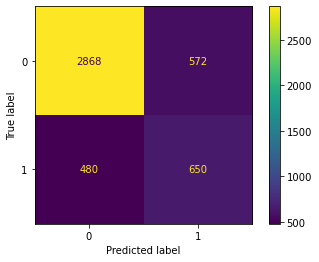

In [60]:
plot_confusion_matrix(XGB_best_bal, X_test, y_test);

----------------------------------------------------

# V. Select Best Model

In [61]:
%%time
%%capture --no-display

models = [
    ('Dummy (Baseline)', dummy),
    ('LogReg', LR),
    ('LogReg_best', LR_best), 
    ('LogReg_best_bal', LR_best_bal),
    ('RandomForest', RF),
    ('RandomForest_best', RF_best),
    ('RandomForest_best_bal', RF_best_bal),
    ('SVC_Linear', SVC_linear_best),
    ('SVC_Linear_bal', SVC_linear_best_bal),
    ('SVC_RBF', SVC_rbf_best),
    ('SVC_RBF_bal', SVC_rbf_best_bal),
    ('XGB', XGB),
    ('XGB_best', XGB_best),
    ('XGB_best_bal', XGB_best_bal)
]

scoring = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']

results= {}
for name, model in models:
    results[name] = {}
    for i in scoring:        
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=5, return_train_score=True)
        results[name][i] = scores

Wall time: 37min 27s


In [62]:
Precision_Train = []
Precision_Test = []
Recall_Train = []
Recall_Test = []
Accuracy_Train = []
Accuracy_Test = []
F1_Test = []
AUC_Test = []

for model in results.keys():
    # Precision
    pr_train_mean = results[model]['precision']['train_score'].mean()*100
    pr_test_mean = results[model]['precision']['test_score'].mean()*100
    Precision_Train.append(round(pr_train_mean, 2))
    Precision_Test.append(round(pr_test_mean, 2))
    
    # Recall
    rec_train_mean = results[model]['recall']['train_score'].mean()*100
    rec_test_mean = results[model]['recall']['test_score'].mean()*100
    Recall_Train.append(round(rec_train_mean, 2))
    Recall_Test.append(round(rec_test_mean, 2))
    
    # Accuracy
    acc_train_mean = results[model]['accuracy']['train_score'].mean()*100
    acc_test_mean = results[model]['accuracy']['test_score'].mean()*100
    Accuracy_Train.append(round(acc_train_mean, 2))
    Accuracy_Test.append(round(acc_test_mean, 2))
    
    # F1
    f1_test_mean = results[model]['f1']['test_score'].mean()*100
    F1_Test.append(round(f1_test_mean, 2))
    
    # AUC
    auc_test_mean = results[model]['roc_auc']['test_score'].mean()
    AUC_Test.append(round(auc_test_mean, 4))
    
# Save model names and parameters as list
names = []
steps = []
for name, model in models:
    names.append(str(name))
    if hasattr(model, 'named_steps'):
        steps.append(str(list(model.named_steps.values())[1]))
    else:
        steps.append(model)

In [63]:
#pd.options.display.max_colwidth = 100

model_compare = pd.DataFrame(
    {'Model': names,
     'Precision_Test': Precision_Test,
     'Recall_Test': Recall_Test,
     'Acc_Train': Accuracy_Train, 'Acc_Test': Accuracy_Test,
     'F1_Test': F1_Test,
     'AUC_Test': AUC_Test,
     #'Parameters': steps
    }
)

model_compare

,Model,Precision_Test,Recall_Test,Acc_Train,Acc_Test,F1_Test,AUC_Test
0,Dummy (Baseline),0.00,0.00,75.29,75.29,0.00,0.5000
1,LogReg,60.25,24.91,77.36,77.40,34.96,0.7441
2,LogReg_best,61.60,7.85,76.06,76.00,13.90,0.7471
3,LogReg_best_bal,46.74,63.14,73.44,73.25,53.73,0.7547
4,RandomForest,54.08,38.75,99.70,76.75,45.12,0.7498
5,RandomForest_best,59.00,35.57,81.29,78.10,43.90,0.7783
6,RandomForest_best_bal,55.84,58.03,80.08,78.13,56.71,0.7802
7,SVC_Linear,60.11,37.10,78.37,78.35,45.87,0.7547
8,SVC_Linear_bal,47.10,63.05,73.70,73.27,53.78,0.7531
9,SVC_RBF,64.66,5.52,76.01,75.91,10.16,0.7124
